In [2]:

 !pip install -q scikit-learn pandas nltk spacy joblib matplotlib seaborn xgboost
 !python -m spacy download en_core_web_sm -q


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import csr_matrix, hstack

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK downloads (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print(" All libraries imported successfully.")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pawanyadav/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pawanyadav/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pawanyadav/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pawanyadav/nltk_data...


 All libraries imported successfully.


In [4]:
FILE_PATH = r"/Users/pawanyadav/Desktop/training.1600000.processed.noemoticon.csv"

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}")

# Load dataset
colnames = ['target', 'ids', 'date', 'query', 'user', 'text']
df = pd.read_csv(FILE_PATH, names=colnames, encoding='latin-1', low_memory=False)

# Filter only 0 and 4 classes
df = df[df['target'].isin([0, 4])]
df['label'] = df['target'].map({0: 0, 4: 1})

print("✅ Dataset loaded successfully.")
print("Shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())
display(df.head())


✅ Dataset loaded successfully.
Shape: (1600000, 7)
Label distribution:
 label
0    800000
1    800000
Name: count, dtype: int64


,target,ids,date,query,user,text,label
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


In [7]:
#Data Sampling (optional for speed)
MAX_PER_CLASS = 50000  # set None for full data
if MAX_PER_CLASS:
    df_bal = (df.groupby('label', group_keys=False)
                .apply(lambda x: x.sample(n=min(len(x), MAX_PER_CLASS), random_state=42)))
else:
    df_bal = df.copy()

df_bal = df_bal.sample(frac=1, random_state=42).reset_index(drop=True)
print(" Sampled data shape:", df_bal.shape)
print(df_bal['label'].value_counts())


 Sampled data shape: (100000, 7)
label
1    50000
0    50000
Name: count, dtype: int64


/var/folders/gk/lp0zwdjd4738gspdqpnswmrm0000gn/T/ipykernel_17515/2374651381.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), MAX_PER_CLASS), random_state=42)))


In [10]:

import re
import nltk
from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# 1️ Download required NLTK resources
nltk_packages = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4']
for pkg in nltk_packages:
    try:
        nltk.data.find(f"tokenizers/{pkg}" if pkg.startswith('punkt') else f"corpora/{pkg}")
    except LookupError:
        print(f"Downloading NLTK package: {pkg} ...")
        nltk.download(pkg, quiet=True)

# 2️ Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
wn = WordNetLemmatizer()

# 3️ Define helper functions
def clean_text(s):
    if s is None:
        return ""
    s = str(s)
    s = s.replace("\n"," ").replace("\r"," ")
    s = re.sub(r'http\S+', ' ', s)     # remove URLs
    s = re.sub(r'@\w+', ' ', s)        # remove mentions
    s = re.sub(r'#', '', s)            # remove hashtags symbol
    s = re.sub(r"[^A-Za-z0-9\s']", " ", s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s.lower()

def regex_tokenize(text):
    return re.findall(r"[A-Za-z0-9']+", text)

def safe_tokenize(text):
    """Try NLTK tokenizer; if it fails, fallback to regex."""
    try:
        toks = word_tokenize(text)
        return [t for t in toks if str(t).strip()]
    except Exception:
        return regex_tokenize(text)

def remove_stop(tokens):
    return [t for t in tokens if t.isalpha() and t.lower() not in stop_words]

def lemmatize_tokens(tokens):
    return [wn.lemmatize(t.lower()) for t in tokens if t.isalpha()]

# 4️ Apply preprocessing to df_bal
tqdm.pandas()

texts = df_bal['text'].fillna("").astype(str).tolist()

print(" Cleaning text...")
cleaned = [clean_text(t) for t in tqdm(texts)]

print(" Tokenizing...")
tokens_list = [safe_tokenize(t) for t in tqdm(cleaned)]

print(" Removing stopwords...")
tokens_nostop = [remove_stop(toks) for toks in tqdm(tokens_list)]

print(" Lemmatizing...")
lemmas = [lemmatize_tokens(toks) for toks in tqdm(tokens_nostop)]

print(" Joining tokens...")
lemmas_join = [" ".join(toks) for toks in lemmas]

# 5️ Attach results back to df_bal
df_bal['clean'] = cleaned
df_bal['tokens'] = tokens_list
df_bal['tokens_nostop'] = tokens_nostop
df_bal['lemmas'] = lemmas
df_bal['lemmas_join'] = lemmas_join

# 6️ Sanity check
print("\n Preprocessing complete!")
display(df_bal[['text','clean','lemmas_join']].head(5))

empty_count = sum(1 for s in df_bal['lemmas_join'] if len(s.strip()) == 0)
print(f"\n Empty rows after preprocessing: {empty_count}/{len(df_bal)}")


 Cleaning text...


  0%|          | 0/100000 [00:00<?, ?it/s]

 Tokenizing...


  0%|          | 0/100000 [00:00<?, ?it/s]

 Removing stopwords...


  0%|          | 0/100000 [00:00<?, ?it/s]

 Lemmatizing...


  0%|          | 0/100000 [00:00<?, ?it/s]

 Joining tokens...

 Preprocessing complete!


,text,clean,lemmas_join
0,@stargazer60 that's awesome,that's awesome,awesome
1,@cunningstunts22 yes... i am!,yes i am,yes
2,N my bed aaallll alone,n my bed aaallll alone,n bed aaallll alone
3,@Thorney88 re guinea fowl ive heard that lots ...,re guinea fowl ive heard that lots of people d...,guinea fowl ive heard lot people dislike say f...
4,def going to the movies tonite,def going to the movies tonite,def going movie tonite



 Empty rows after preprocessing: 525/100000


In [12]:
# ===== FEATURE ENGINEERING + MODELS (fixed to use lemmas_join / clean) =====

import os, joblib, numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1) Select the right preprocessed text column
if 'lemmas_join' in df_bal.columns:
    text_col = 'lemmas_join'
elif 'clean' in df_bal.columns:
    text_col = 'clean'
elif 'clean_text' in df_bal.columns:
    text_col = 'clean_text'
else:
    text_col = 'text'   # fallback to raw text (not ideal)

print("Using text column:", text_col)

# 2) Drop rows with empty text (after preprocessing)
before = len(df_bal)
df_fe = df_bal[df_bal[text_col].astype(str).str.strip() != ""].copy().reset_index(drop=True)
after = len(df_fe)
dropped = before - after
print(f"Dropped {dropped} empty rows. Remaining rows: {after}")

if after == 0:
    raise SystemExit("No non-empty rows to vectorize. Check preprocessing results.")

# 3) TF-IDF and BoW
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_tfidf = tfidf.fit_transform(df_fe[text_col].astype(str).values)
print("TF-IDF shape:", X_tfidf.shape)

cv = CountVectorizer(ngram_range=(1,1), max_features=10000)
X_bow = cv.fit_transform(df_fe[text_col].astype(str).values)
print("BoW shape:", X_bow.shape)

# 4) SVD embeddings (dense)
n_comp = min(100, max(1, X_tfidf.shape[1]-1))
svd = TruncatedSVD(n_components=n_comp, random_state=42)
X_emb = svd.fit_transform(X_tfidf)
print("SVD embedding shape:", X_emb.shape)

# 5) Handcrafted numeric features (computed on raw 'text' column for signal)
import re
def has_url(text): return int(bool(re.search(r'http', str(text))))
def has_mention(text): return int(bool(re.search(r'@\w+', str(text))))
def has_hashtag(text): return int(bool(re.search(r'#\w+', str(text))))
def uppercase_count(text): return sum(1 for ch in str(text) if ch.isupper())
def digit_count(text): return sum(1 for ch in str(text) if ch.isdigit())

# prefer raw 'text' if exists, else use the chosen column
raw_text_col = 'text' if 'text' in df_fe.columns else text_col
df_fe['len_chars'] = df_fe[raw_text_col].astype(str).map(len)
df_fe['has_url'] = df_fe[raw_text_col].apply(has_url)
df_fe['has_mention'] = df_fe[raw_text_col].apply(has_mention)
df_fe['has_hashtag'] = df_fe[raw_text_col].apply(has_hashtag)
df_fe['uppercase_count'] = df_fe[raw_text_col].apply(uppercase_count)
df_fe['digit_count'] = df_fe[raw_text_col].apply(digit_count)

dense_cols = ['len_chars','has_url','has_mention','has_hashtag','uppercase_count','digit_count']
dense_mat = df_fe[dense_cols].fillna(0).astype(float).values
print("Dense features shape:", dense_mat.shape)

# 6) Train/test split (stratify on label)
y = df_fe['label'].astype(int).values
X_tr, X_te, y_tr, y_te, idx_tr, idx_te = train_test_split(X_tfidf, y, df_fe.index.values,
                                                           test_size=0.2, random_state=42, stratify=y)
print("Train label counts:", np.bincount(y_tr), " Test label counts:", np.bincount(y_te))

# 7) MultinomialNB on TF-IDF
mnb = MultinomialNB()
mnb.fit(X_tr, y_tr)
pred_mnb = mnb.predict(X_te)
print("\nMultinomialNB (TF-IDF) results:")
print("Accuracy:", accuracy_score(y_te, pred_mnb))
print(classification_report(y_te, pred_mnb))
print("Confusion matrix:\n", confusion_matrix(y_te, pred_mnb))

# 8) Logistic Regression on TF-IDF + dense
scaler = MinMaxScaler()
dense_scaled = scaler.fit_transform(dense_mat)
dense_sparse = csr_matrix(dense_scaled)

# build dense train/test using df_fe indices (idx_tr / idx_te are positions in df_fe)
dense_tr = dense_sparse[np.searchsorted(df_fe.index.values, idx_tr), :]
dense_te = dense_sparse[np.searchsorted(df_fe.index.values, idx_te), :]

# If the above indexing fails for any reason, fallback to simpler slicing:
# dense_tr = dense_sparse[idx_tr - df_fe.index.min(), :]
# dense_te = dense_sparse[idx_te - df_fe.index.min(), :]

X_comb_tr = hstack([X_tr, dense_tr], format='csr')
X_comb_te  = hstack([X_te, dense_te], format='csr')

lr = LogisticRegression(max_iter=2000, class_weight='balanced')
lr.fit(X_comb_tr, y_tr)
pred_lr = lr.predict(X_comb_te)
print("\nLogisticRegression (TF-IDF + dense) results:")
print("Accuracy:", accuracy_score(y_te, pred_lr))
print(classification_report(y_te, pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_te, pred_lr))

# 9) Show a few misclassified examples (LR)
wrong_idx = np.where(pred_lr != y_te)[0]
print(f"\nMisclassified count (LR): {len(wrong_idx)}. Showing up to 8:")
for i in wrong_idx[:8]:
    ri = idx_te[i]         # index into df_fe
    print("\n---")
    print("Text:", df_fe.at[ri, raw_text_col])
    print("True label:", int(df_fe.at[ri,'label']), " Pred:", int(pred_lr[i]))

# 10) Save artifacts locally
os.makedirs("sentiment_models", exist_ok=True)
joblib.dump(tfidf, "sentiment_models/tfidf_vectorizer.joblib")
joblib.dump(mnb, "sentiment_models/mnb_model.joblib")
joblib.dump(lr, "sentiment_models/logistic_model.joblib")
print("\nSaved models to ./sentiment_models/")

# Done
print("\n Feature engineering + training complete.")


Using text column: lemmas_join
Dropped 525 empty rows. Remaining rows: 99475
TF-IDF shape: (99475, 20000)
BoW shape: (99475, 10000)
SVD embedding shape: (99475, 100)
Dense features shape: (99475, 6)
Train label counts: [39817 39763]  Test label counts: [9954 9941]

MultinomialNB (TF-IDF) results:
Accuracy: 0.7527016838401609
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      9954
           1       0.75      0.75      0.75      9941

    accuracy                           0.75     19895
   macro avg       0.75      0.75      0.75     19895
weighted avg       0.75      0.75      0.75     19895

Confusion matrix:
 [[7508 2446]
 [2474 7467]]

LogisticRegression (TF-IDF + dense) results:
Accuracy: 0.7656195023875345
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      9954
           1       0.76      0.78      0.77      9941

    accuracy                           0.77     19895
   macr

In [14]:
# ===== ALIGN, VECTORIZE, SPLIT, TRAIN  =====
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix, hstack

# 0) choose which preprocessed text column to use
if 'lemmas_join' in df_bal.columns:
    text_col = 'lemmas_join'
elif 'clean' in df_bal.columns:
    text_col = 'clean'
elif 'clean_text' in df_bal.columns:
    text_col = 'clean_text'
else:
    text_col = 'text'
print("Using text column:", text_col)

# 1) Drop empty rows (important) and create df_feat — these are the rows we'll vectorize and label
df_feat = df_bal[df_bal[text_col].astype(str).str.strip() != ""].copy().reset_index(drop=True)
print(f"Rows before dropping empty: {len(df_bal)}, after: {len(df_feat)} (dropped {len(df_bal)-len(df_feat)})")

# 2) Sanity check labels align
print("Label distribution in df_feat:\n", df_feat['label'].value_counts())

# 3) Vectorize from df_feat (not df_bal)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_tfidf = tfidf.fit_transform(df_feat[text_col].astype(str).values)
print("X_tfidf shape:", X_tfidf.shape)

# 4) (Optional) build simple dense features for later use (computed on raw text column if available)
raw_col = 'text' if 'text' in df_feat.columns else text_col
import re
def has_url(t): return int(bool(re.search(r'http', str(t))))
def has_mention(t): return int(bool(re.search(r'@\w+', str(t))))
def has_hashtag(t): return int(bool(re.search(r'#\w+', str(t))))
def uppercase_count(t): return sum(1 for ch in str(t) if ch.isupper())
def digit_count(t): return sum(1 for ch in str(t) if ch.isdigit())

df_feat['len_chars'] = df_feat[raw_col].astype(str).map(len)
df_feat['has_url'] = df_feat[raw_col].apply(has_url)
df_feat['has_mention'] = df_feat[raw_col].apply(has_mention)
df_feat['has_hashtag'] = df_feat[raw_col].apply(has_hashtag)
df_feat['uppercase_count'] = df_feat[raw_col].apply(uppercase_count)
df_feat['digit_count'] = df_feat[raw_col].apply(digit_count)
dense_cols = ['len_chars','has_url','has_mention','has_hashtag','uppercase_count','digit_count']
dense_mat = df_feat[dense_cols].fillna(0).astype(float).values
print("Dense shape:", dense_mat.shape)

# 5) Now split using X_tfidf and df_feat['label'] (same number of rows)
y = df_feat['label'].astype(int).values
X_tr, X_te, y_tr, y_te, idx_tr, idx_te = train_test_split(
    X_tfidf, y, df_feat.index.values, test_size=0.2, random_state=42, stratify=y)

print("Train counts:", np.bincount(y_tr), " Test counts:", np.bincount(y_te))

# 6) MultinomialNB baseline
mnb = MultinomialNB()
mnb.fit(X_tr, y_tr)
pred_mnb = mnb.predict(X_te)
print("\nMultinomialNB (TF-IDF) results:")
print("Accuracy:", accuracy_score(y_te, pred_mnb))
print(classification_report(y_te, pred_mnb))
print("Confusion matrix:\n", confusion_matrix(y_te, pred_mnb))

# 7) LogisticRegression using TF-IDF + dense numeric features
scaler = MinMaxScaler()
dense_scaled = scaler.fit_transform(dense_mat)
dense_sparse = csr_matrix(dense_scaled)
# create dense train/test by selecting rows using idx_tr/idx_te (these are positions in df_feat)
dense_tr = dense_sparse[idx_tr, :]
dense_te = dense_sparse[idx_te, :]

X_comb_tr = hstack([X_tr, dense_tr], format='csr')
X_comb_te = hstack([X_te, dense_te], format='csr')

lr = LogisticRegression(max_iter=2000, class_weight='balanced')
lr.fit(X_comb_tr, y_tr)
pred_lr = lr.predict(X_comb_te)
print("\nLogisticRegression (TF-IDF + dense) results:")
print("Accuracy:", accuracy_score(y_te, pred_lr))
print(classification_report(y_te, pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_te, pred_lr))


Using text column: lemmas_join
Rows before dropping empty: 100000, after: 99475 (dropped 525)
Label distribution in df_feat:
 label
0    49771
1    49704
Name: count, dtype: int64
X_tfidf shape: (99475, 20000)
Dense shape: (99475, 6)
Train counts: [39817 39763]  Test counts: [9954 9941]

MultinomialNB (TF-IDF) results:
Accuracy: 0.7527016838401609
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      9954
           1       0.75      0.75      0.75      9941

    accuracy                           0.75     19895
   macro avg       0.75      0.75      0.75     19895
weighted avg       0.75      0.75      0.75     19895

Confusion matrix:
 [[7508 2446]
 [2474 7467]]

LogisticRegression (TF-IDF + dense) results:
Accuracy: 0.7656195023875345
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      9954
           1       0.76      0.78      0.77      9941

    accuracy                          

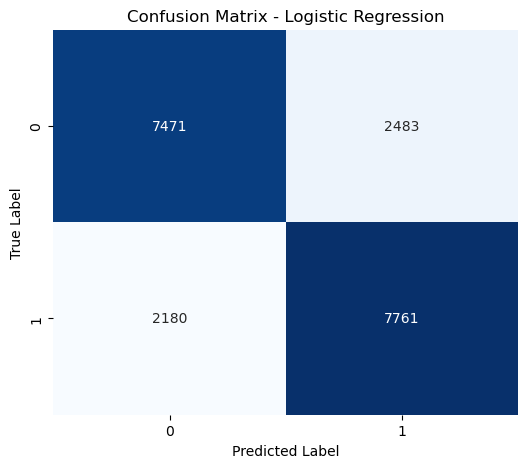

 Confusion matrix plotted successfully.


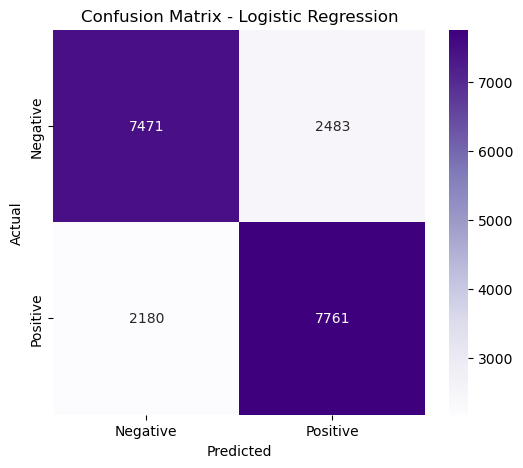

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Use correct variable names
cm = confusion_matrix(y_te, pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(" Confusion matrix plotted successfully.")
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, pred_lr, labels=[0,1])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
#Save Models
os.makedirs("sentiment_models", exist_ok=True)
joblib.dump(tfidf, "sentiment_models/tfidf_vectorizer.joblib")
joblib.dump(mnb, "sentiment_models/naive_bayes_model.joblib")
joblib.dump(lr, "sentiment_models/logistic_model.joblib")
print(" Models saved in 'sentiment_models/' folder.")


 Models saved in 'sentiment_models/' folder.


In [23]:
# ===== FINAL FIXED INFERENCE FUNCTION =====
import os, re, joblib, numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MinMaxScaler

ARTIFACT_DIR = "sentiment_models"  # adjust if you saved elsewhere
dense_scaler_path = os.path.join(ARTIFACT_DIR, "dense_scaler.joblib")

# ---------- Helper to compute dense features ----------
def dense_features_from_texts(texts):
    def has_url(text): return int(bool(re.search(r'http', str(text))))
    def has_mention(text): return int(bool(re.search(r'@\w+', str(text))))
    def has_hashtag(text): return int(bool(re.search(r'#\w+', str(text))))
    def uppercase_count(text): return sum(1 for ch in str(text) if ch.isupper())
    def digit_count(text): return sum(1 for ch in str(text) if ch.isdigit())
    arr = []
    for t in texts:
        arr.append([
            len(str(t)),
            has_url(t),
            has_mention(t),
            has_hashtag(t),
            uppercase_count(t),
            digit_count(t)
        ])
    return np.array(arr, dtype=float)

# ---------- Ensure all artifacts are loaded ----------
def ensure_artifacts():
    global tfidf, lr, mnb, scaler, dense_cols
    if 'dense_cols' not in globals():
        dense_cols = ['len_chars','has_url','has_mention','has_hashtag','uppercase_count','digit_count']
    # load vectorizer
    if 'tfidf' not in globals():
        tfidf_path = os.path.join(ARTIFACT_DIR, "tfidf_vectorizer.joblib")
        if os.path.exists(tfidf_path):
            tfidf = joblib.load(tfidf_path)
            print(" Loaded TF-IDF vectorizer.")
        else:
            raise SystemExit(" TF-IDF not found. Run feature-engineering cell first.")
    # load model
    if 'lr' not in globals():
        lr_path = os.path.join(ARTIFACT_DIR, "logistic_model.joblib")
        if os.path.exists(lr_path):
            lr = joblib.load(lr_path)
            print(" Loaded Logistic Regression model.")
    if 'mnb' not in globals():
        mnb_path = os.path.join(ARTIFACT_DIR, "mnb_model.joblib")
        if os.path.exists(mnb_path):
            mnb = joblib.load(mnb_path)
            print(" Loaded MultinomialNB model.")
    # load or fit scaler
    if 'scaler' not in globals() or scaler is None:
        if os.path.exists(dense_scaler_path):
            scaler = joblib.load(dense_scaler_path)
            print(" Loaded saved scaler.")
        elif 'df_feat' in globals():
            tmp = df_feat[dense_cols].fillna(0).astype(float).values
            scaler = MinMaxScaler().fit(tmp)
            joblib.dump(scaler, dense_scaler_path)
            print(" Fitted new scaler from df_feat.")
        else:
            scaler = None
            print(" Scaler missing. Will fallback to on-the-fly scaling.")

# ---------- Main Predict Function ----------
def predict_sentiment_texts_safe(texts, model=None, vectorizer=None, preprocess_fn=None, allow_padding=False):
    """
    Predict sentiment for a list of texts.
    Handles TF-IDF, dense features, scaling, and feature alignment.
    """
    from scipy.sparse import csr_matrix, hstack  # <-- FIXED: imported inside
    ensure_artifacts()

    if model is None:
        model = globals().get('lr', globals().get('mnb'))
        if model is None:
            raise SystemExit("No trained model found (lr or mnb).")

    if vectorizer is None:
        vectorizer = tfidf

    # ----- Preprocess -----
    if preprocess_fn is None and 'preprocess' in globals():
        preprocess_fn = preprocess

    if preprocess_fn is None:
        # fallback
        def simple_clean(s):
            s = str(s)
            s = re.sub(r'http\S+','', s)
            s = re.sub(r'@\w+','', s)
            s = re.sub(r'#','', s)
            s = re.sub(r"[^A-Za-z0-9\s']", " ", s)
            return re.sub(r'\s+',' ', s).strip().lower()
        processed = [simple_clean(t) for t in texts]
    else:
        processed = [preprocess_fn(t) for t in texts]

    # ----- TF-IDF -----
    X_tfidf_new = vectorizer.transform(processed)
    n_tfidf = X_tfidf_new.shape[1]

    # ----- Dense -----
    dense_new = dense_features_from_texts(texts)
    if 'scaler' in globals() and scaler is not None:
        dense_scaled_new = scaler.transform(dense_new)
    else:
        # fallback scaling
        minv = dense_new.min(axis=0)
        maxv = dense_new.max(axis=0)
        denom = np.where((maxv - minv) == 0, 1.0, (maxv - minv))
        dense_scaled_new = (dense_new - minv) / denom
        print(" Using fallback dense feature scaling.")

    X_dense_sparse = csr_matrix(dense_scaled_new)
    X_combined = hstack([X_tfidf_new, X_dense_sparse], format='csr')

    expected = getattr(model, "n_features_in_", None)
    print(f"🔍 Model expects {expected} features | Current combined: {X_combined.shape[1]}")

    if expected is not None and expected != X_combined.shape[1]:
        if allow_padding:
            pad_n = expected - X_combined.shape[1]
            if pad_n > 0:
                pad = csr_matrix((X_combined.shape[0], pad_n), dtype=float)
                X_combined = hstack([X_combined, pad], format='csr')
                print(f" Added {pad_n} zero-columns to match model input.")
            elif pad_n < 0:
                X_combined = X_combined[:, :expected]
                print(f" Truncated {abs(pad_n)} columns to match model input.")
        else:
            raise ValueError(f"Feature mismatch: model expects {expected}, got {X_combined.shape[1]}.\n"
                             "Re-run with allow_padding=True or retrain using consistent vectorizer+scaler.")

    preds = model.predict(X_combined)
    probs = model.predict_proba(X_combined) if hasattr(model, "predict_proba") else None
    return preds, probs


# ---------- Example test ----------
texts = [
    "I love this movie, it's fantastic!",
    "I really hate the customer service today.",
    "Nothing special, just okay."
]

try:
    preds, probs = predict_sentiment_texts_safe(texts)
    for t, p in zip(texts, preds):
        print(f"{t}\n→ {'Positive' if p == 1 else 'Negative'}\n")
    print(" Inference executed successfully.")
except Exception as e:
    import traceback
    traceback.print_exc()


🔍 Model expects 20006 features | Current combined: 20006
I love this movie, it's fantastic!
→ Positive

I really hate the customer service today.
→ Negative

Nothing special, just okay.
→ Positive

 Inference executed successfully.
